# analysis of placement of created tips
Tim Tyree<br>
7.12.2023

In [8]:
import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *
os.chdir(nb_dir)
from lib import *
# import cupy, cudf
# from lib.rapids_func import *
import seaborn as sns
import matplotlib.ticker as mtick
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

In [9]:
import seaborn as sns
#reset matplotlib
plt.plot([1]*4)
plt.close()
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

# dev

In [262]:
printing=True
use_save_df_to_parquet_by=True
use_save_df_to_parquet_by=False
#load fortranic tip positions
folder=f"{nb_dir}/Data/from_wjr/positions_fk/200x200"
fn = 'tippos_per_c_001'
# folder=f"{nb_dir}/Data/from_wjr/positions_lr/200x200"
# fn = 'tippos_per_001'
input_dir = os.path.join(folder,fn)
log_folder_parquet=f'{folder}/positions'
assert os.path.exists(input_dir)
if use_save_df_to_parquet_by:
    df_log=parse_fortranic_tip_pos(input_dir)
    #partition df_log into a folder of tip logs
    save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    print(f"saved to spiral tip positions to {log_folder_parquet=}")
    #determine width and height of the computational domain input the discretization
    width,height=df_log.describe().loc['max'][['x','y']].values.T
    del df_log
else:
    width=200
    height=200

In [52]:
DX=0.025
# min_num_tips=6
min_num_tips=4
# printing=False
n_lst=[]
Rvec_lst=[]
dist0_lst=[]
distance_L2_pbc = get_distance_L2_pbc(width=width, height=height)
for fn in os.listdir(log_folder_parquet):
    try:
        trial_num = eval(fn.split('=')[1])
        # load tip position data
        g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
        DT=g['t'].min()
        n_series = g.groupby(by='t')['n'].min()
        t_values_birth = n_series[n_series.diff()==2.].index.values
        for tb in t_values_birth:
            n=n_series.loc[tb]
            if n>=min_num_tips:
                d_prev = g.loc[g['t']==tb-DT]
                d_next = g.loc[g['t']==tb]
                #track the particles in this and the next frame only
                id_pair_lst,disp_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
                if len(id_pair_lst)>=min_num_tips-2:  #<<< removes cases where it fails to track
                    xy_values = d_next[['x','y']].values
                    #select the new tips
                    i_new_tips = tuple(set(range(n)).difference(np.array(id_pair_lst)[:,1]))
                    i_old_tips = tuple(set(range(n)).difference(i_new_tips))
                    #compute the distance between them
                    dist0=distance_L2_pbc(xy_values[i_new_tips[0]],xy_values[i_new_tips[1]])
                    mindist=10*width
                    minj=-1
                    mini=-1
                    #for each new tip
                    Rvec=np.zeros(min_num_tips-2,dtype='float')
                    for i in i_new_tips:
                        xy=xy_values[i]
                        #compute the distance to nearest preexisting tip
                        dist_lst=[]
                        for j in i_old_tips:
                            dist=distance_L2_pbc(xy,xy_values[j])
                            dist_lst.append(dist)   
                        jarray = np.argsort(dist_lst)[:min_num_tips-2]
                        Rvec+=np.array(dist_lst)[jarray][:min_num_tips-2]*DX #cm
                    Rvec/=len(i_new_tips)
                    #record
                    Rvec_lst.append(Rvec)
                    n_lst.append(n)
                    dist0_lst.append(dist0)
    except IndexError as e:
        pass
print (f"{len(n_lst)=}")
beep(3)

len(n_lst)=36616


0

In [53]:
# fn

In [54]:
# for tb in t_values_birth:
#     d_prev = g.loc[g['t']==tb-DT]
#     d_next = g.loc[g['t']==tb]
#     id_pair_lst,disp_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)        
#DONE: check that local tracking is working
# fig,ax=plt.subplots(figsize=(3,2))
# d_next.plot(kind='scatter',x='x',y='y',marker='.',ax=ax,color='k')

# for ii,(i1,i2) in enumerate(id_pair_lst):
#     ax.scatter(x=d_prev['x'].values[i1],
#                 y=d_prev['y'].values[i1],
#                 c=f'C{ii}',marker='s')
#     ax.scatter(x=d_next['x'].values[i2],
#                 y=d_next['y'].values[i2],
#                 c=f'C{ii}',marker='*',edgecolor='k')
# # format_plot
# ax.axis([0,width,0,height])
# format_plot(xlabel='x (pxl)',ylabel='y (pxl)',fontsize=12,ax=ax)
# ax.tick_params(top=True, right=True,direction='in',which='both')
# plt.show()

In [55]:
X=np.array(Rvec_lst)
#TODO: make a 3d scatter plot of ^that
# R1,R2,R3,R4 = zip(*X)
R1,R2 = zip(*X)
# (R3+R4)/2
R1=np.array(R1)
R2=np.array(R2)
# R3=np.array(R3)
# R4=np.array(R4)
R0=np.array(dist0_lst)*DX

In [56]:

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(R1,R2,R3+R4,marker='.',color='k')
# ax.set_xlabel('R1')
# ax.set_ylabel('R2')
# ax.set_zlabel('R3')
# plt.show()
# X.shape,len(R1)#,R3.shape

In [57]:
# fontsize=16
# fig = plt.figure()
# ax = fig.add_subplot(111)#, projection='3d')
# ax.scatter(R1,R4,marker='.',color='k')
# # ax.scatter((R1+R2)/2,(R3+R4)/2,marker='.',color='k')
# # ax.scatter(np.divide(R1,R4),np.divide(R2,R4),marker='.',color='k')
# # ax.scatter(np.divide(2*R1,R3+R4),np.divide(2*R2,R3+R4),marker='.',color='k')
# # xv=np.arange(0,1,0.1)
# xv=np.arange(0,3,0.1)
# ax.plot(xv,xv,'k--')
# # format_plot(xlabel=r'$R_1/R_3$',ylabel=r'$R_2/R_3$',ax=ax,fontsize=fontsize)
# # format_plot(xlabel=r'$R_1/R_4$',ylabel=r'$R_2/R_4$',ax=ax,fontsize=fontsize)  #<<<good
# # format_plot(xlabel=r'$(R_1+R_2)/2$  (cm)',ylabel=r'$(R_3+R_4)/2$  (cm)',ax=ax,fontsize=fontsize)
# format_plot(xlabel=r'$R_1$  (cm)',ylabel=r'$R_4$  (cm)',ax=ax,fontsize=fontsize)
# # format_plot(xlabel=r'$2R_1/(R_3+R_4)$',ylabel=r'$2R_2/(R_3+R_4)$',ax=ax,fontsize=fontsize)
# ax.tick_params(top=True, right=True,direction='in',which='both')
# plt.show()
# #heretim

In [58]:
#DONE: make a 2d scatter plot of R1/R3,R2/R3
#TODO: repeat over many trials
#TODO: consider hdbscan to identify a cluster with R1,R2 about the same / much smaller than R3

In [59]:
# fontsize=16
# fig = plt.figure()
# ax = fig.add_subplot(111)#, projection='3d')
# # ax.scatter(R1,R4,marker='.',color='k')
# # x=R1;y=R4
# # x=(R1+R2)/2;y=(R3+R4)/2
# # x=np.divide(R1,R4);y=np.divide(R2,R4)
# x=np.divide(2*R1,R3+R4);y=np.divide(2*R2,R3+R4)
# sns.kdeplot(x=x,y=y,cmap=plt.cm.gray_r)#,extent=[xmin, xmax, ymin, ymax])
# ax.scatter(x,y,marker='.',color='k')
# # ax.scatter(,marker='.',color='k')
# # ax.scatter(,marker='.',color='k')
# xv=np.arange(0,1,0.1)
# # xv=np.arange(0,3,0.1)
# ax.plot(xv,xv,'k--')
# # format_plot(xlabel=r'$R_1$  (cm)',ylabel=r'$R_4$  (cm)',ax=ax,fontsize=fontsize)
# # format_plot(xlabel=r'$(R_1+R_2)/2$  (cm)',ylabel=r'$(R_3+R_4)/2$  (cm)',ax=ax,fontsize=fontsize)
# # format_plot(xlabel=r'$R_1/R_3$',ylabel=r'$R_2/R_3$',ax=ax,fontsize=fontsize)
# # format_plot(xlabel=r'$R_1/R_4$',ylabel=r'$R_2/R_4$',ax=ax,fontsize=fontsize)  #<<<good
# format_plot(xlabel=r'$2R_1/(R_3+R_4)$',ylabel=r'$2R_2/(R_3+R_4)$',ax=ax,fontsize=fontsize)
# ax.tick_params(top=True, right=True,direction='in',which='both')
# plt.show()
# #heretim

In [62]:
meanx,Delta_meanx,num_obs,p_normal=comp_mean_bootstrap_uncertainty(R0)
meanx1,Delta_meanx1,num_obs1,p_normal1=comp_mean_bootstrap_uncertainty(R1)
if printing:
    print(f"FK: mean R0: {meanx:.4f} +/- {Delta_meanx:.4f} (N={num_obs}, {p_normal=:.4f})")
    print(f"FK: mean R1: {meanx1:.4f} +/- {Delta_meanx1:.4f} (N={num_obs1}, {p_normal1=:.4f})")

FK: mean R0: 0.1316 +/- 0.0011 (N=36616, p_normal=0.3324)
FK: mean R1: 0.7750 +/- 0.0035 (N=36616, p_normal1=0.3707)


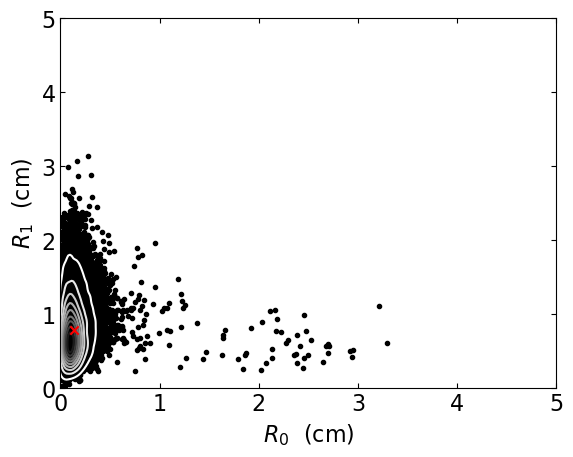

In [64]:
fontsize=16
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')
x=R0; y=R1;
sns.kdeplot(x=x,y=y,cmap=plt.cm.gray_r)#,extent=[xmin, xmax, ymin, ymax])
ax.scatter(x,y,marker='.',color='k')
xv=np.arange(0,1,0.1)
# ax.plot(xv,xv,'k--')
# ax.scatter(x=[0.202],y=[1.25],marker='x',color='r',zorder=10)
# ax.scatter(x=[0.204],y=[0.830],marker='x',color='r',zorder=10)
ax.scatter(x=[0.132],y=[0.775],marker='x',color='r',zorder=10)
# ax.scatter(x=[meanx],y=[meanx1],marker='x',color='r',zorder=10)
ax.axis([0,5,0,5])
format_plot(xlabel=r'$R_0$  (cm)',ylabel=r'$R_1$  (cm)',ax=ax,fontsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()

In [49]:
meanx,Delta_meanx,num_obs,p_normal=comp_mean_bootstrap_uncertainty(R0)
meanx1,Delta_meanx1,num_obs1,p_normal1=comp_mean_bootstrap_uncertainty(R1)
if printing:
    print(f"LR: mean R0: {meanx:.4f} +/- {Delta_meanx:.4f} (N={num_obs}, {p_normal=:.4f})")
    print(f"LR: mean R1: {meanx1:.4f} +/- {Delta_meanx1:.4f} (N={num_obs1}, {p_normal1=:.4f})")

LR: mean R0: 0.2036 +/- 0.0029 (N=14204, p_normal=0.2342)
LR: mean R1: 0.8303 +/- 0.0074 (N=14204, p_normal1=0.3893)


In [10]:
beep(3)



0

In [47]:
#DONE: load tip positions from wj
#DONE: identify creation events
#DONE: compute the distance from the mean new tip position to each other tip using periodic b.c.'s
#DONE: order other tips by distance to new tip pair
#DONE: select the first three or four other ranges for creations with at least N0 tips
#DONE: make a 3d scatter plot of ^that
#DONE: make a 2d scatter plot of R1/R3,R2/R3
#TODO: consider hdbscan to identify a cluster with R1,R2 about the same / much smaller than R3

In [48]:
dist0_lst
dist0_dir = os.path.join(folder,'creation_ranges.npz')
np.savez_compressed(dist0_dir,dist0_lst)
print(f"{dist0_dir=}")

dist0_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/creation_ranges.npz'


# plot the distribution of ranges at the time of creation between the newly created tips

In [63]:
DX=0.025 #cm/px

In [64]:
dist0_dir_fk='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/creation_ranges.npz'
dist0_lst_fk=np.load(dist0_dir_fk)['arr_0']*DX
dist0_dir_lr='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/creation_ranges.npz'
dist0_lst_lr=np.load(dist0_dir_lr)['arr_0']*DX

In [65]:
beep(2)



0

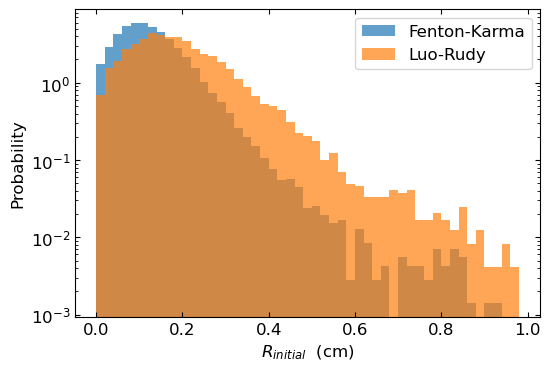

In [77]:
# figsize=(3,2)
figsize=(6,4)
# figsize=(7,5)
fig,ax=plt.subplots(figsize=figsize)
bins=20
bins=np.arange(0.0,1,0.02)
ax.hist(dist0_lst_fk,color='C0',label='Fenton-Karma',density=True,alpha=0.7,bins=bins)
ax.hist(dist0_lst_lr,color='C1',label='Luo-Rudy',density=True,alpha=0.7,bins=bins)

# format_plot
ax.legend(fontsize=12)
# ax.set_xscale('log')
ax.set_yscale('log')
format_plot(xlabel=r'$R_{initial}$  (cm)',ylabel='Probability',fontsize=12,ax=ax)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()

In [ ]:
#Q: what are the mean values?

In [83]:
np.random.seed(42)
meanx,Delta_meanx,num_obs,p_normal=comp_mean_bootstrap_uncertainty(dist0_lst_fk)
printing=True
if printing:
    print(f"FK: mean: {meanx:.4f} +/- {Delta_meanx:.4f} (N={num_obs}, {p_normal=:.4f})")
    
meanx,Delta_meanx,num_obs,p_normal=comp_mean_bootstrap_uncertainty(dist0_lst_lr)
if printing:
    print(f"LR: mean: {meanx:.4f} +/- {Delta_meanx:.4f} (N={num_obs}, {p_normal=:.4f})")

FK: mean: 0.1312 +/- 0.0012 (N=35637, p_normal=0.7488)
LR: mean: 0.2016 +/- 0.0032 (N=12155, p_normal=0.1176)


In [259]:
# dist_pbc

# TODO: compute F_cardiac
then,
- TODO: compute F_particle

In [6]:
# #   FK          LR
# # r 0.457±0.009 0.314±0.003
# r=.1 #cm
# threshR=r/DX
# # print(f"{threshR=:.4} pixels")

In [2]:
DX=0.025
mindur=100 #ms

In [36]:
#   FK          LR
# r 0.457±0.009 0.314±0.003
r=0.1 #cm
# r=0.25 #cm
r = 0.457#±0.009 cm #FK
# r = 0.314#±0.003 cm #LR
threshR=r/DX
# print(f"{threshR=:.4} pixels")

In [37]:
printing=True
use_save_df_to_parquet_by=True
use_save_df_to_parquet_by=False
#load fortranic tip positions
folder=f"{nb_dir}/Data/from_wjr/positions_fk/200x200"
fn = 'tippos_per_c_001'
# folder=f"{nb_dir}/Data/from_wjr/positions_lr/200x200"
# fn = 'tippos_per_001'
input_dir = os.path.join(folder,fn)
log_folder_parquet=f'{folder}/positions'
assert os.path.exists(input_dir)
if use_save_df_to_parquet_by:
    df_log=parse_fortranic_tip_pos(input_dir)
    #partition df_log into a folder of tip logs
    save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    print(f"saved to spiral tip positions to {log_folder_parquet=}")
    #determine width and height of the computational domain input the discretization
    width,height=df_log.describe().loc['max'][['x','y']].values.T
    del df_log
else:
    width=200
    height=200

In [38]:
#heretim
#TODO: dev compute_min_range_timeseries_reversed

In [39]:
def compute_min_range_timeseries(trial_num,log_folder_parquet,DX,mindur,threshR,max_num_entries=10,
                                 **kwargs):
    minR_lst_lst=[]
    # load tip position data
    g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
    DT=g['t'].min()
    n_series = g.groupby(by='t')['n'].min()
    t_values_birth = n_series[n_series.diff()==2.].index.values
    t_values_birth = t_values_birth[t_values_birth>=100].copy()  #throw out first 100 ms
    for tb in t_values_birth:
        t=tb
        tprev=g.loc[g['t']<t,'t'].max()
        d_next = g.loc[g['t']==t]
        d_prev = g.loc[(g['t']==tprev)]#.shift(-1)
        DT = t - tprev
        id_pair_lst_,disp_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
        #for each new tip
        numparticles=d_next.shape[0]
        new_particle_indices = np.setdiff1d(list(range(numparticles)),[x[1] for x in list(id_pair_lst_)])
        for index_self in new_particle_indices:
            t=tb
            tprev=g.loc[g['t']<t,'t'].max()
            d_next = g.loc[g['t']==t]
            d_prev = g.loc[(g['t']==tprev)]#.shift(-1)
            numparticles=d_next.shape[0]
            index_other_values=np.setdiff1d(list(range(numparticles)),[index_self])
            #compute the minimum initial range to another tip
            dist_values=np.zeros(numparticles)
            xy_self=d_next.iloc[index_self][['x','y']].values
            for index_other in index_other_values:
                xy_other=d_next.iloc[index_other][['x','y']].values
                dist=distance_L2_pbc(xy_self,xy_other)
                dist_values[index_other]=dist
            minR = dist_values[dist_values>0].min()
            #track minR over time, throwing out the first mindur time points
            #track the next particle
            tnext=g.loc[g['t']>t,'t'].min()
            d_prev = g.loc[g['t']==t]
            d_next = g.loc[(g['t']==tnext)]#.shift(-1)
            numparticles = d_next.shape[0]
            index_self_update=-1
            if numparticles>0:
                id_pair_lst,disp_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
                for index_self_old,index_self_new in id_pair_lst:
                    if index_self==index_self_old:
                        index_self_update=index_self_new
            index_self = index_self_update
        #     print(index_self)
            dur=float(DT)
            minR_lst=[]
            index_self_lst=[]
            while index_self!=-1:
                t=tnext
                dur+=DT
                #track the next particle
                tnext=g.loc[g['t']>t,'t'].min()
                d_prev = g.loc[g['t']==t]
                d_next = g.loc[(g['t']==tnext)]#.shift(-1)
                numparticles = d_next.shape[0]
                index_self_update=-1
                if numparticles>0:
                    id_pair_lst,disp_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
                    for index_self_old,index_self_new in id_pair_lst:
                        if index_self==index_self_old:
                            index_self_update=index_self_new
                index_self = index_self_update
        #         index_self_lst.append(index_self)
                # throwing out the first mindur time points
                if (numparticles>0)&(dur>=mindur):
                    index_other_values=np.setdiff1d(list(range(numparticles)),[index_self])
                    #compute the minimum range to another tip
                    dist_values=np.zeros(numparticles,dtype='float')
                    xy_self=d_next.iloc[index_self][['x','y']].values
                    for index_other in index_other_values:
                        xy_other=d_next.iloc[index_other][['x','y']].values
                        dist=distance_L2_pbc(xy_self,xy_other)
                        dist_values[index_other]=dist
                    minR = dist_values[dist_values>0].min()
                    minR_lst.append(minR)
#                 if len(minR_lst)>0:
            if (len(minR_lst)>0) and (minR<threshR): #constrain to trajectories that end within threshold
                #trajectory was longer than mindur in duration, consider trajectory in later analysis
                minR_lst_lst.append(minR_lst)
        #         minR_lst_lst.append(list(reversed(minR_lst)))
                #early stopping for tip tracking
                if max_num_entries<len(minR_lst_lst):
                    return minR_lst_lst
    return minR_lst_lst

In [29]:
minR_lst_lst=[]
distance_L2_pbc = get_distance_L2_pbc(width=width, height=height)
task_lst=[]
for fn in os.listdir(log_folder_parquet):
    trial_num = eval(fn.split('=')[1])
    task = trial_num,log_folder_parquet,DX,mindur,threshR
    task_lst.append(task)
print(f"{len(task_lst)=}")
def routine(task):
        trial_num,log_folder_parquet,DX,mindur,threshR = task
        try:
            return compute_min_range_timeseries(trial_num,log_folder_parquet,DX,mindur,threshR)
        except IndexError as e:
#                 print(f"skipping trail #{trial_num=}...")
#                 pass        
            return []

len(task_lst)=81


In [30]:
ncores = os.cpu_count()-1
retval_lst = eval_routine_multiprocess(routine, task_lst, ncores)
beep(4)
# minR_lst_lst=[]
# for minR_lst in retval_lst:
#     minR_lst_lst.extend(minR_lst)
# len(minR_lst_lst)



0

In [31]:
# minR_lst_lst=[]
# for minR_lst in retval_lst:
#     minR_lst_lst.append(minR_lst)
# len(minR_lst_lst)

In [32]:
minR_lst_lst=[]
for minR_lst in retval_lst:
    minR_lst_lst.extend(minR_lst)
len(minR_lst_lst)

316

In [33]:
dict_lst=[]
count=0
for minR_lst in minR_lst_lst:
    nobs=len(minR_lst)
    if nobs==0:
        count+=1
    else:
        #trajectory was longer than mindur in duration, consider
        minR = np.min(minR_lst)
        #compute a large number of minR_lst values
        boo_in_range = np.array(minR_lst)<threshR
        ends_in_range = boo_in_range[-1]
        leaves_in_range=False
        if ends_in_range:
            #check if trajectory leaves in_range status
            i0=np.argwhere(boo_in_range)[0][0]
            if i0<(nobs-1): 
                leaves_in_range = boo_in_range[i0:].all()
        #record
        dict_lst.append(dict(
            minR=minR,nobs=nobs,
            ends_in_range=ends_in_range,
            leaves_in_range=leaves_in_range,
        ))
print(f"{count} entries had zero observations")
len(dict_lst)

# identify sum1 out of sum2 trajectories that enter range r stay in range r
df=pd.DataFrame(dict_lst)
sum1=df['leaves_in_range'].sum()
sum2=df['ends_in_range'].sum()
# record F_cardiac
F_cardiac = 1-sum1/sum2
print(f"{sum1} out of {sum2} trajectories left range {r=} cm ({F_cardiac=:.4%})")

0 entries had zero observations
40 out of 316 trajectories left range r=0.1 cm (F_cardiac=87.3418%)


In [ ]:
# 6 out of 99 trajectories left range r=0.1 cm (F_cardiac=93.9394%) (LR)
# 40 out of 316 trajectories left range r=0.1 cm (F_cardiac=87.3418%)

In [34]:
beep(3)



0

In [35]:
#TODO: save inputs that quickly yield F_cardiac
#DONE: dev generator for F_LPM
dirout = input_dir+'_minR_lst_lst.npz'
np.savez_compressed(dirout,minR_lst_lst)
print(f"{dirout=}")

dirout='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_minR_lst_lst.npz'


In [102]:
dirout='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_minR_lst_lst.npz'
dirout='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_minR_lst_lst.npz'
# minR_lst_lst = list(np.load(dirout).values())
minR_lst_lst = list(np.load(dirout, allow_pickle=True).values())[0]

# list(np.load(dirout).values())
# ar=np.load(dirout)['arr_0']
# list(np.load(dirout).keys())
len(minR_lst_lst)

99

In [103]:
# ar[0]

In [104]:
#   FK          LR
# r 0.457±0.009 0.314±0.003
r=0.1 #cm
# r2=0.2 #cm
r2=0.15 #cm
# r2=0.2 #cm
# r=0.25 #cm
# r = 0.457#±0.009 cm #FK
# r = 0.314#±0.003 cm #LR
threshR=r/DX
threshR2=r2/DX
# print(f"{threshR=:.4} pixels")
threshR #pixels

4.0

In [105]:
dict_lst=[]
count=0
for minR_lst in minR_lst_lst:
    nobs=len(minR_lst)
    if nobs==0:
        count+=1
    else:
        #trajectory was longer than mindur in duration, consider
        minR = np.min(minR_lst)
        #compute a large number of minR_lst values
        boo_in_range = np.array(minR_lst)<threshR
#         boo_in_range2 = np.array(minR_lst)<threshR2
        ends_in_range = boo_in_range[-1]
        leaves_in_range=False
        if ends_in_range:
            #check if trajectory leaves in_range status
            i0=np.argwhere(boo_in_range)[0][0]
#             i0=np.argwhere(boo_in_range2)[0][0]
            if i0<(nobs-1): 
                leaves_in_range = boo_in_range[i0:].all()
#                 leaves_in_range = boo_in_range2[i0:].all()
        #check if it really leaves the outer range at any point
        if leaves_in_range:
            boo_in_range2 = np.array(minR_lst)<threshR2
            booir=boo_in_range2[i0:]
            if booir.all():
                #then the pair never leaves the outer range, disregard
                leaves_in_range=False
#             pass
        #record
        dict_lst.append(dict(
            minR=minR,nobs=nobs,
            ends_in_range=ends_in_range,
            leaves_in_range=leaves_in_range,
        ))
print(f"{count} entries had zero observations")
len(dict_lst)

# identify sum1 out of sum2 trajectories that enter range r stay in range r
df=pd.DataFrame(dict_lst)
sum1=df['leaves_in_range'].sum()
sum2=df['ends_in_range'].sum()
# record F_cardiac
# F_cardiac = 1-sum1/sum2
F_cardiac = sum1/sum2
# print(f"{sum1} out of {sum2} trajectories left range {r=} cm ({F_cardiac=:.4%})")
print(f"{sum1} out of {sum2} trajectories left range {r=} cm and then left {r2=} cm ({F_cardiac=:.4%})")

0 entries had zero observations
0 out of 99 trajectories left range r=0.1 cm and then left r2=0.15 cm (F_cardiac=0.0000%)


In [90]:
#FK
# 198 out of 316 trajectories left range r=0.457 cm (F_cardiac=37.3418%)
# 40 out of 316 trajectories left range r=0.1 cm (F_cardiac=87.3418%)
# 0 out of 316 trajectories left range r=0.1 cm and then left r2=0.2 cm (F_cardiac=0.0000%)

#LR
# 77 out of 99 trajectories left range r=0.314 cm (F_cardiac=22.2222%)
# 6 out of 99 trajectories left range r=0.1 cm (F_cardiac=93.9394%)
# 0 out of 99 trajectories left range r=0.1 cm and then left r2=0.2 cm (F_cardiac=0.0000%)

In [64]:
len(minR_lst_lst[0])

316

In [79]:
#DONE: identify enter range r stay in range r
#DONE: identify sum1 out of sum2 trajectories that enter range r stay in range r
#DONE: record F_cardiac
#DONE: parallelize routine(task)
#DONE: compute a larger number of minR_lst values
#DONE: repeat for other full model
#DONE: repeat for LPM
#DONE: record F_LPM

In [5]:
#DONE: look for already tracked particle positions
#>>> there are none...